##### References
- **[Calculate indicators](#Calculate-indicators)**
    - [Return](#Return)
    - [RSI](#RSI)
    - [Gain/lose](#Gain/lose)
    - [Average gain/loss](#Average-gain/loss)
    - [MA](#MA)
    - [Moving Average Convergence Divergence (MACD)](#Moving-Average-Convergence-Divergence-(MACD))
    - [Stochastic Oscillator](#Stochastic-Oscillator)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
    - [Bollinger Bands](#Bollinger-Bands)

<br>
    
- **[Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)**

    - [RSI](#RSI-decision)
        - [RSI backtesting](#RSI-backtesting)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
        - [Williams backtesting](#Williams-backtesting)
     - [MA](#MA-decision)
        - [MA backtesting](#MA-backtesting)
    - [MACD](#MACD-decision)
        - [MACD backtesting](#MACD-backtesting)
    - [Bollinger Bands](#Bollinger-Bands-decision)
        - [Bollinger Bands](#Bollinger-Bands-backtesting)

    
   


***

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import backtesting
# from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *
import random

import warnings
warnings.filterwarnings("ignore")

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MAGISTERKA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data download

In [3]:
stocks = ['EURUSD=X', '^GSPC']

start_data = '2019-04-04'  # (RRR-MM-DD)
end_data = '2024-04-04'  # (RRR-MM-DD)

for stock in stocks:
    data = yf.download(stock, start_data, end_data)
    df = pd.DataFrame(data)
    df['Name'] = stock  # add column with symbol
    df.to_csv(stock + '.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Load data

In [4]:
data = pd.read_csv('EURUSD=X.csv')

In [5]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1304.00,1304.00,1304.00,1304.00,1304.00,1304.0
mean,1.11,1.12,1.11,1.11,1.11,0.0
std,0.06,0.06,0.06,0.06,0.06,0.0
min,0.96,0.97,0.95,0.96,0.96,0.0
25%,1.08,1.08,1.08,1.08,1.08,0.0
50%,1.11,1.11,1.10,1.11,1.11,0.0
75%,1.16,1.16,1.16,1.16,1.16,0.0
max,1.23,1.24,1.23,1.23,1.23,0.0


In [27]:
# Convert 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
start, end = '2019-04', '2024-04'
pd.set_option('display.max_columns', None)

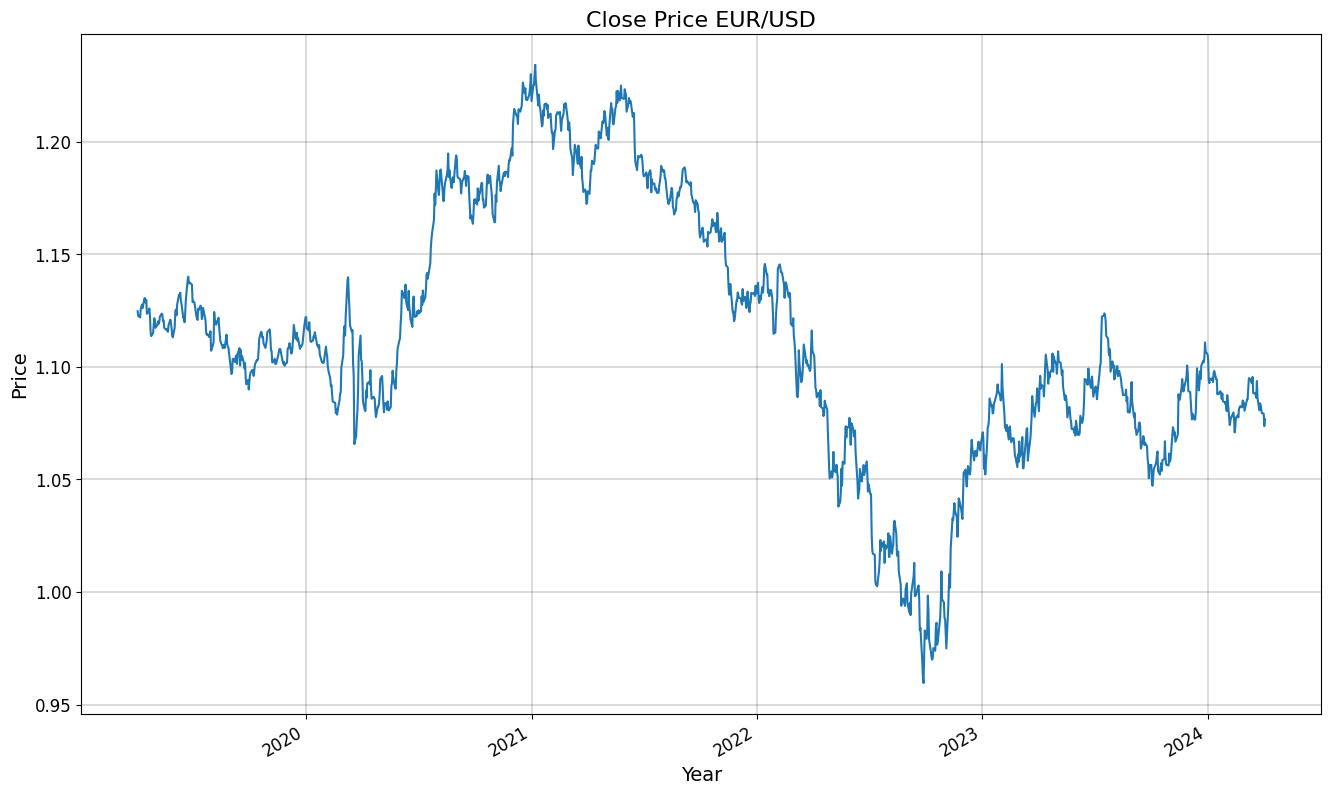

In [28]:
data.groupby('Name')['Close'].plot(figsize=(16, 10))

# Show the legend
#plt.legend(loc = 'upper left')

# Define the label for the title of the figure
plt.title("Close Price EUR/USD", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-', linewidth=0.2)

plt.show()

In [7]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.0
mean,1.113533,1.116847,1.110091,1.113561,1.113561,0.0
std,0.056675,0.056203,0.057109,0.056694,0.056694,0.0
min,0.959619,0.967006,0.954016,0.959619,0.959619,0.0
25%,1.080106,1.083403,1.077218,1.080176,1.080176,0.0
50%,1.106856,1.109107,1.103077,1.106752,1.106752,0.0
75%,1.159400,1.161181,1.156370,1.159568,1.159568,0.0
max,1.233776,1.235025,1.226693,1.234111,1.234111,0.0


# Calculate indicators

In [6]:
price_data = data.copy()
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2019-04-04,1.124531,1.124986,1.120925,1.124695,1.124695,0,EURUSD=X
1,2019-04-05,1.122460,1.124151,1.121164,1.122586,1.122586,0,EURUSD=X
2,2019-04-08,1.122208,1.127408,1.121554,1.121957,1.121957,0,EURUSD=X
3,2019-04-09,1.125644,1.128796,1.125644,1.125644,1.125644,0,EURUSD=X
4,2019-04-10,1.126494,1.128286,1.123103,1.126697,1.126697,0,EURUSD=X


## Return

In [7]:
# Identify rows where the symbol changes
mask = price_data['Name'] != price_data['Name'].shift(1)

# Calculate log return
price_data['Return'] = np.log(price_data['Close']) -  np.log(price_data['Close'].shift(1))

# For rows where symbol changes set null
price_data['Return'] = np.where(mask == True, np.nan, price_data['Return'])


## Gain/lose


In [8]:
# Set '0' if 'Up' is below 0
price_data['Up'] = price_data['Return']
price_data.loc[(price_data['Up']<0), 'Up'] = 0
 
# Set '0' if 'Down' above 0
price_data['Down'] = price_data['Return']
price_data.loc[(price_data['Down']>0), 'Down'] = 0 
 
# Set the absolute value for negative values
price_data['Down'] = abs(price_data['Down'])

## Average gain/loss

In [9]:
# 14-days averages
price_data['avg_14up'] = price_data.groupby('Name')['Up'].transform(lambda x: x.rolling(window=14).mean())
price_data['avg_14down'] = price_data.groupby('Name')['Down'].transform(lambda x: x.rolling(window=14).mean())


## RSI

In [10]:
# Calculate RS

price_data['RS_14'] = price_data['avg_14up'] / price_data['avg_14down']

# Calculate RSI

price_data['RSI'] = 100 - (100/(1 + price_data['RS_14']))

## RSI na cenach
****

# [Wzory](https://www.macroption.com/rsi-calculation/)

In [43]:
# Calculate bar-to-bar changes
price_data['chng'] = price_data['Close'].diff()

# Calculate Up moves (U) and Down moves (D)
price_data['Up_c'] = price_data['chng'].copy()
price_data['Down_c'] = price_data['chng'].copy()

# Set 'Up' to 0 if 'chng' is negative or zero
price_data.loc[price_data['chng'] <= 0, 'Up_c'] = 0

# Set 'Down' to 0 if 'chng' is positive or zero
price_data.loc[price_data['chng'] >= 0, 'Down_c'] = 0

price_data['Down_c'] = abs(price_data['Down_c'])


In [77]:
# Calculate simple moving averages for AvgU and AvgD
N = 14  # RSI period

price_data['AvgU_avg'] = price_data['Up_c'].rolling(window=N, min_periods=1).mean()
price_data['AvgD_avg'] = price_data['Down_c'].rolling(window=N, min_periods=1).mean()

price_data['RS_avg'] =price_data['AvgU_avg']/ price_data['AvgD_avg']

In [78]:
price_data['RSI_avg'] = 100 - (100/(1+price_data['RS_avg']))

In [50]:
price_data.tail(15)

,Open,High,Low,Close,Adj Close,Volume,Name,Return,chng,Up,Down,AvgU,AvgD,RS,RSI,avg_14up,avg_14down,RS_14,Up_c,Down_c,RSI_c
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-14,1.095530,1.095470,1.088412,1.095530,1.095530,0,EURUSD=X,0.002517,0.002753,0.002517,0.000000,0.001454,0.000528,2.752684,73.318689,0.001337,0.000486,2.747942,0.002753,0.000000,73.352404
2024-03-15,1.088341,1.090156,1.087382,1.088341,1.088341,0,EURUSD=X,-0.006584,-0.007190,0.000000,0.006584,0.001454,0.001002,1.451783,59.241470,0.001337,0.000920,1.453474,0.000000,0.007190,59.213364
2024-03-18,1.088258,1.090750,1.088080,1.088258,1.088258,0,EURUSD=X,-0.000076,-0.000083,0.000000,0.000076,0.001234,0.001008,1.224343,55.053553,0.001133,0.000925,1.224870,0.000000,0.000083,55.042912
2024-03-19,1.087394,1.087784,1.083506,1.087394,1.087394,0,EURUSD=X,-0.000794,-0.000864,0.000000,0.000794,0.001234,0.001026,1.202864,54.617621,0.001133,0.000941,1.203498,0.000000,0.000864,54.604559
2024-03-20,1.086331,1.087429,1.083694,1.086331,1.086331,0,EURUSD=X,-0.000978,-0.001063,0.000000,0.000978,0.001234,0.001059,1.165231,53.829375,0.001133,0.000972,1.165879,0.000000,0.001063,53.815552
2024-03-21,1.093721,1.094451,1.085647,1.093721,1.093721,0,EURUSD=X,0.006780,0.007390,0.006780,0.000000,0.001762,0.000817,2.156218,68.363506,0.001617,0.000748,2.160906,0.007390,0.000000,68.316508
2024-03-22,1.086236,1.086957,1.080906,1.086236,1.086236,0,EURUSD=X,-0.006867,-0.007485,0.000000,0.006867,0.001492,0.001352,1.103944,52.482426,0.001368,0.001239,1.104485,0.000000,0.007485,52.470213
2024-03-25,1.080754,1.084363,1.080264,1.080754,1.080754,0,EURUSD=X,-0.005060,-0.005482,0.000000,0.005060,0.001403,0.001743,0.804825,44.559249,0.001286,0.001600,0.803727,0.000000,0.005482,44.592971
2024-03-26,1.083823,1.086413,1.082603,1.083823,1.083823,0,EURUSD=X,0.002836,0.003069,0.002836,0.000000,0.001616,0.001743,0.927198,48.103029,0.001483,0.001600,0.926895,0.003069,0.000000,48.111189


### Wilder's Smoothing Method

In [72]:

# Calculate bar-to-bar changes
price_data['chng'] = price_data['Close'].diff()

# Calculate Up moves (U) and Down moves (D)
price_data['Up_c'] = price_data['chng'].copy()
price_data['Down_c'] = price_data['chng'].copy()

# Set 'Up' to 0 if 'chng' is negative or zero
price_data.loc[price_data['chng'] <= 0, 'Up_c'] = 0

# Set 'Down' to 0 if 'chng' is positive or zero
price_data.loc[price_data['chng'] >= 0, 'Down_c'] = 0

price_data['Down_c'] = abs(price_data['Down_c'])

# Calculate Wilder's smoothing method for AvgU and AvgD
N = 14  # RSI period

price_data['AvgU'] = 0.0
price_data['AvgD'] = 0.0

# Calculate initial values for AvgU and AvgD
price_data.loc[price_data.index[N-1], 'AvgU'] = price_data['Up_c'].iloc[:N].mean()
price_data.loc[price_data.index[N-1], 'AvgD'] = price_data['Down_c'].iloc[:N].mean()

# Calculate AvgU and AvgD using Wilder's smoothing method
for i in range(N, len(price_data)):
    price_data.loc[price_data.index[i], 'AvgU'] = (1/N) * price_data['Up_c'].iloc[i] + ((N - 1)/N) * price_data['AvgU'].iloc[i-1]
    price_data.loc[price_data.index[i], 'AvgD'] = (1/N) * price_data['Down_c'].iloc[i] + ((N - 1)/N) * price_data['AvgD'].iloc[i-1]

# Calculate RS and RSI using AvgU and AvgD
price_data['RS'] = price_data['AvgU'] / price_data['AvgD']
price_data['RSI_c'] = 100 - (100 / (1 + price_data['RS']))


In [73]:
price_data.dropna()
price_data.iloc[19:50].head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,Down,avg_14up,avg_14down,RS_14,RSI,chng,Up_c,Down_c,AvgU,AvgD,RS,RSI_c
19,2019-05-01,1.121831,1.124999,1.121441,1.121604,1.121604,0,EURUSD=X,0.002755,0.002755,0.000000,0.001009,0.001393,0.724430,42.009839,0.003086,0.003086,0.000000,0.001207,0.001255,0.961562,49.020220
20,2019-05-02,1.120185,1.121818,1.117356,1.120084,1.120084,0,EURUSD=X,-0.001356,0.000000,0.001356,0.001009,0.001390,0.725960,42.061230,-0.001520,0.000000,0.001520,0.001121,0.001274,0.879627,46.797958
21,2019-05-03,1.117256,1.120072,1.114132,1.117356,1.117356,0,EURUSD=X,-0.002439,0.000000,0.002439,0.000729,0.001565,0.465894,31.782222,-0.002728,0.000000,0.002728,0.001041,0.001378,0.755246,43.027913
22,2019-05-06,1.118706,1.120448,1.117993,1.118581,1.118581,0,EURUSD=X,0.001096,0.001096,0.000000,0.000807,0.001564,0.516176,34.044584,0.001225,0.001225,0.000000,0.001054,0.001280,0.823614,45.163825
23,2019-05-07,1.120448,1.121957,1.117606,1.120185,1.120185,0,EURUSD=X,0.001433,0.001433,0.000000,0.000910,0.001438,0.632523,38.745106,0.001604,0.001604,0.000000,0.001093,0.001188,0.920021,47.917228
24,2019-05-08,1.118956,1.121500,1.118956,1.119107,1.119107,0,EURUSD=X,-0.000963,0.000000,0.000963,0.000833,0.001507,0.552800,35.600215,-0.001078,0.000000,0.001078,0.001015,0.001180,0.860000,46.236560
25,2019-05-09,1.119746,1.125100,1.117568,1.119833,1.119833,0,EURUSD=X,0.000649,0.000649,0.000000,0.000879,0.001119,0.785891,44.005533,0.000727,0.000727,0.000000,0.000995,0.001096,0.907363,47.571608
26,2019-05-10,1.121856,1.125239,1.121856,1.122208,1.122208,0,EURUSD=X,0.002119,0.002119,0.000000,0.000976,0.001119,0.872352,46.591245,0.002375,0.002375,0.000000,0.001093,0.001018,1.074045,51.785048
27,2019-05-13,1.123671,1.126342,1.122410,1.123646,1.123646,0,EURUSD=X,0.001280,0.001280,0.000000,0.000976,0.001119,0.872191,46.586644,0.001438,0.001438,0.000000,0.001118,0.000945,1.182690,54.184972
28,2019-05-14,1.123242,1.124606,1.120486,1.123255,1.123255,0,EURUSD=X,-0.000348,0.000000,0.000348,0.000976,0.000924,1.056439,51.372253,-0.000391,0.000000,0.000391,0.001038,0.000906,1.146191,53.405830


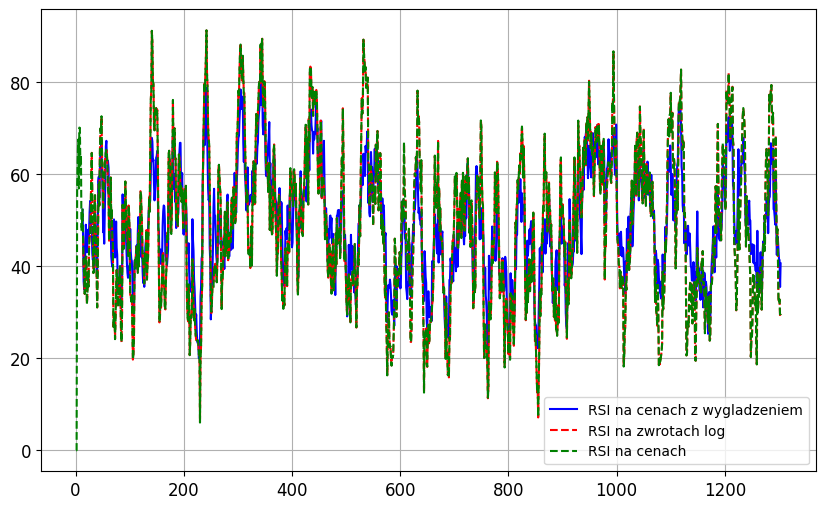

In [81]:
plt.figure(figsize=(10, 6))


plt.plot(price_data.index, price_data['RSI_c'], label='RSI na cenach z wygladzeniem', color='blue')

plt.plot(price_data.index, price_data['RSI'], label='RSI na zwrotach log', color='red', linestyle='dashed')
plt.plot(price_data.index, price_data['RSI_avg'], label='RSI na cenach', color='green', linestyle='dashed')

plt.legend()


plt.grid(True)
plt.show()


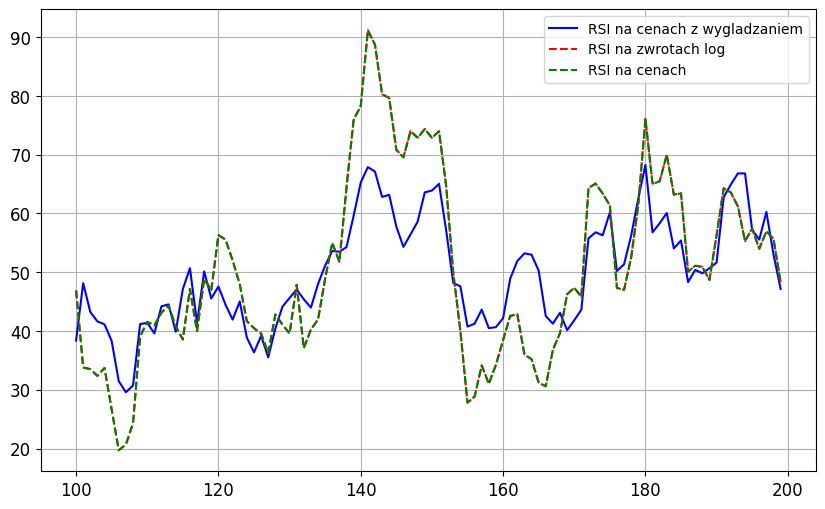

In [83]:
plt.figure(figsize=(10, 6))


plt.plot(price_data.iloc[100:200].index, price_data['RSI_c'].iloc[100:200], label='RSI na cenach z wygladzaniem', color='blue')

plt.plot(price_data.iloc[100:200].index, price_data['RSI'].iloc[100:200], label='RSI na zwrotach log', color='red', linestyle='dashed')
plt.plot(price_data.iloc[100:200].index, price_data['RSI_avg'].iloc[100:200], label='RSI na cenach', color='green', linestyle='dashed')

plt.legend()


plt.grid(True)
plt.show()


****

## Pozostałe wskaźniki:

## MA

In [11]:
price_data["5MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 5).mean())
price_data["15MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 15).mean())

## Moving Average Convergence Divergence (MACD)

In [12]:
# Calculate 12 and 26 EWM
price_data['12Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
price_data['26Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

# Calculate MACD
price_data['MACD'] = price_data['12Ewm'] - price_data['26Ewm']


## Stochastic Oscillator

In [13]:
# Period
n = 14

# Group by the symbol and then take max and min 
price_data['low_14'] = price_data.groupby('Name')['Low'].transform(lambda x: x.rolling(window = n).min())
price_data['high_14'] = price_data.groupby('Name')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the stochastic oscillator
price_data['k_percent']  = 100 * ((price_data['Close'] - price_data['low_14']) / (price_data['high_14'] - price_data['low_14']))

## Williams %R ('r_percent')

In [14]:
# Period
n = 14

# Calculate Williams %R
price_data['r_percent'] = -100 * ((price_data['high_14'] - price_data['Close']) / (price_data['high_14'] - price_data['low_14']))



## Bollinger Bands
[Bollinger Bands](https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/)

In [15]:
def bollinger_bands(df, n, m):
    result = df.copy()  
    
    # Initialize new columns with NaN values
    result['B_MA'] = np.nan
    result['BU'] = np.nan
    result['BL'] = np.nan
    
    grouped = df.groupby('Name')
    
    for name, group in grouped:
        data = group['Close']
        
        B_MA = data.rolling(n, min_periods=n).mean()
        sigma = data.rolling(n, min_periods=n).std()
        
        BU = B_MA + m * sigma
        BL = B_MA - m * sigma
        
        # Assign calculated values to the corresponding rows in the result DataFrame
        result.loc[group.index, 'B_MA'] = B_MA
        result.loc[group.index, 'BU'] = BU
        result.loc[group.index, 'BL'] = BL
    
    return result

In [16]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(price_data, 20, 2)

In [17]:
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2019-04-04,1.124531,1.124986,1.120925,1.124695,1.124695,0,EURUSD=X,NaN,NaN,...,1.124695,1.124695,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-05,1.122460,1.124151,1.121164,1.122586,1.122586,0,EURUSD=X,-0.001876,0.000000,...,1.124371,1.124539,-0.000168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-08,1.122208,1.127408,1.121554,1.121957,1.121957,0,EURUSD=X,-0.000561,0.000000,...,1.123999,1.124347,-0.000348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-04-09,1.125644,1.128796,1.125644,1.125644,1.125644,0,EURUSD=X,0.003281,0.003281,...,1.124252,1.124444,-0.000191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-10,1.126494,1.128286,1.123103,1.126697,1.126697,0,EURUSD=X,0.000935,0.000935,...,1.124628,1.124610,0.000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-04-11,1.127612,1.128745,1.125606,1.127650,1.127650,0,EURUSD=X,0.000845,0.000845,...,1.125093,1.124836,0.000258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-04-12,1.125936,1.132503,1.125834,1.126075,1.126075,0,EURUSD=X,-0.001397,0.000000,...,1.125244,1.124927,0.000317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-04-15,1.130365,1.132246,1.129943,1.130506,1.130506,0,EURUSD=X,0.003926,0.003926,...,1.126054,1.125341,0.000713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-04-16,1.130442,1.131500,1.128605,1.130493,1.130493,0,EURUSD=X,-0.000011,0.000000,...,1.126737,1.125722,0.001014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-04-17,1.128515,1.132375,1.128184,1.128503,1.128503,0,EURUSD=X,-0.001762,0.000000,...,1.127008,1.125928,0.001080,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Delete lines with NaN values
df = df.dropna()

# Display how much we have left now
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))


Before NaN Drop we have 1304 rows and 27 columns
After NaN Drop we have 1285 rows and 27 columns


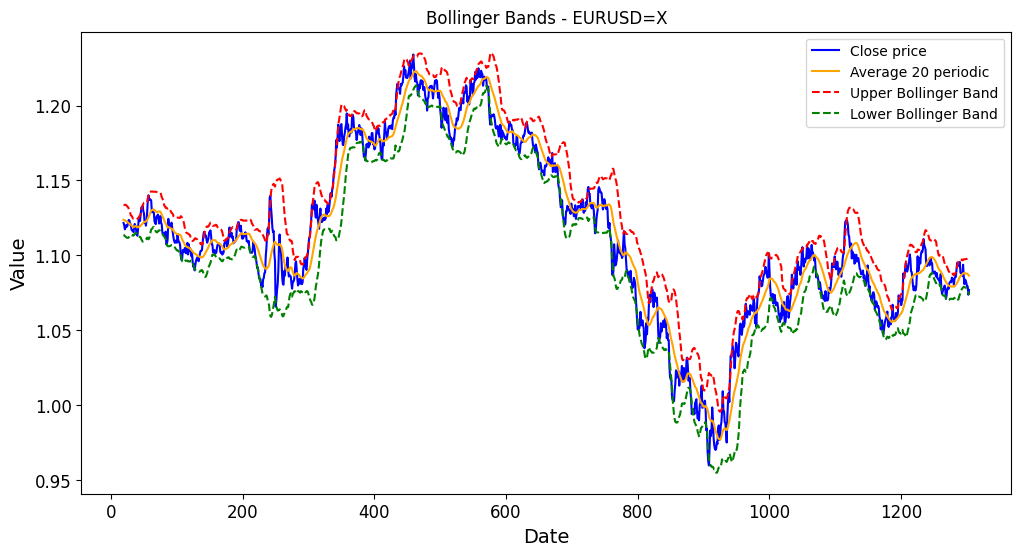

In [19]:
grouped = df.groupby('Name')

for name, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.title(f'Bollinger Bands - {name}')
    
    plt.plot(group.index, group['Close'], label='Close price', color='blue') 
    plt.plot(group.index, group['B_MA'], label=f'Average {n} periodic', color='orange')  
    plt.plot(group.index, group['BU'], label=f'Upper Bollinger Band', color='red', linestyle='--') 
    plt.plot(group.index, group['BL'], label=f'Lower Bollinger Band', color='green', linestyle='--') 
   
    plt.legend()  
    plt.xlabel('Date') 
    plt.ylabel('Value') 
    plt.show()

In [20]:
df[['B_MA', 'BU', 'BL','Close']]

,B_MA,BU,BL,Close
19,1.123754,1.133748,1.113760,1.121604
20,1.123524,1.133638,1.113409,1.120084
21,1.123262,1.133743,1.112782,1.117356
22,1.123093,1.133769,1.112417,1.118581
23,1.122820,1.133501,1.112140,1.120185
...,...,...,...,...
1299,1.087801,1.097600,1.078002,1.081338
1300,1.087749,1.097722,1.077775,1.079447
1301,1.087499,1.098071,1.076926,1.079273
1302,1.086909,1.099134,1.074684,1.073722


## Export file

In [22]:
#df.to_csv("indicators_eurusd_d.csv", index=False, encoding='utf-8-sig')
#df.to_csv("indicators_eurusd_d_4Y.csv", index=False, encoding='utf-8-sig')
df.to_csv("indicators_eurusd_d_5Y.csv", index=False, encoding='utf-8-sig')

## [References](#References)

***

# Fuzzyfication and backtesting

- **Start:** Data rozpoczęcia symulacji backtestu.
- **End:** Data zakończenia symulacji backtestu.
- **Duration:** Czas trwania symulacji backtestu.
- **Exposure Time [%]:** Procent czasu, w którym kapitał był inwestowany w rynku.
- **Equity Final [\$]:** Ostateczny kapitał na koniec symulacji.
- **Equity Peak [\$]:** Najwyższy osiągnięty poziom kapitału.
- **Return [%]:** Procentowy zwrot kapitału w trakcie symulacji.
- **Buy & Hold Return [%]:** Procentowy zwrot kapitału w przypadku strategii buy & hold.
- **Return (Ann.) [%]:** Procentowy zwrot kapitału na rok.
- **Volatility (Ann.) [%]:** Procentowa zmienność na rok.
- **Sharpe Ratio:** Wskaźnik Sharpe'a.
- **Sortino Ratio:** Wskaźnik Sortino.
- **Calmar Ratio:** Wskaźnik Calmara.
- **Max. Drawdown [%]:** Maksymalne obniżenie kapitału.
- **Avg. Drawdown [%]:** Średnie obniżenie kapitału.
- **Max. Drawdown Duration:** Okres trwania maksymalnego obniżenia kapitału.
- **Avg. Drawdown Duration:** Średni okres trwania obniżenia kapitału.
- **# Trades:** Liczba przeprowadzonych transakcji.
- **Win Rate [%]:** Procent transakcji z zyskiem.
- **Best Trade [%]:** Najlepszy zysk z pojedynczej transakcji.
- **Worst Trade [%]:** Najgorsza strata z pojedynczej transakcji.
- **Avg. Trade [%]:** Średni zysk lub strata z pojedynczej transakcji.
- **Max. Trade Duration:** Maksymalny czas trwania pojedynczej transakcji.
- **Avg. Trade Duration:** Średni czas trwania pojedynczej transakcji.
- **Profit Factor:** Wskaźnik zysku.
- **Expectancy [%]:** Oczekiwany zysk w każdej transakcji.
- **SQN:** System Quality Number.
- **Kelly Criterion:** Wskaźnik Kelly'ego.


set_trailing_sl - Ustawia przyszły trailing stop-loss jako pewną wielokrotność (n_atr) średnich rzeczywistych zakresów słupków od bieżącej ceny. [TrailingStrategy]
def next -> trade.sl() - Stop-loss price at which to close the trade. This variable is writable. By assigning it a new price value, you create or modify the existing SL order. By assigning it None, you cancel it.


***

In [8]:
# df = pd.read_csv('data/indicators_eurusd_d.csv')

In [2]:
df = pd.read_csv('data/indicators_eurusd_d_5Y.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2019-05-01,1.121831,1.124999,1.121441,1.121604,1.121604,0,EURUSD=X,0.002755,0.002755,...,1.121055,1.122917,-0.001862,1.112174,1.132503,46.389534,-53.610466,1.123754,1.133748,1.113760
1,2019-05-02,1.120185,1.121818,1.117356,1.120084,1.120084,0,EURUSD=X,-0.001356,0.000000,...,1.120906,1.122707,-0.001801,1.112174,1.132375,39.158607,-60.841393,1.123524,1.133638,1.113409
2,2019-05-03,1.117256,1.120072,1.114132,1.117356,1.117356,0,EURUSD=X,-0.002439,0.000000,...,1.120360,1.122311,-0.001951,1.112174,1.132375,25.653116,-74.346884,1.123262,1.133743,1.112782
3,2019-05-06,1.118706,1.120448,1.117993,1.118581,1.118581,0,EURUSD=X,0.001096,0.001096,...,1.120086,1.122035,-0.001949,1.112174,1.132375,31.716601,-68.283399,1.123093,1.133769,1.112417
4,2019-05-07,1.120448,1.121957,1.117606,1.120185,1.120185,0,EURUSD=X,0.001433,0.001433,...,1.120101,1.121898,-0.001796,1.112174,1.130600,43.475167,-56.524833,1.122820,1.133501,1.112140


## RSI decision


In [4]:
data = df

In [5]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] <= 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] >= 70, 'dec_rsi'] = 'SELL'

    return df

In [6]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    979
BUY     163
SELL    143
Name: count, dtype: int64

In [7]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)

# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS BUY)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS SELL)"
FS.add_rules([R1, R2, R3])

data['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



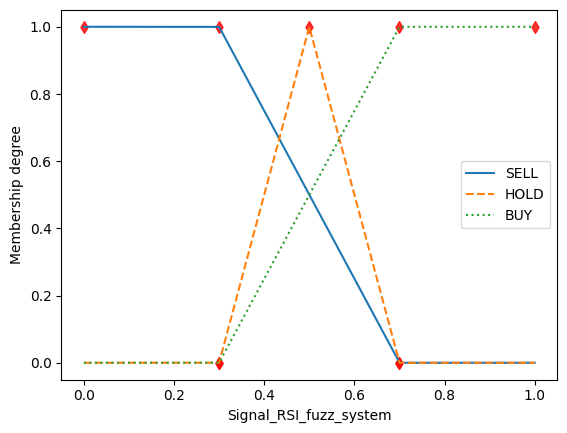

In [8]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [9]:
data['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    897
SELL    209
BUY     179
Name: count, dtype: int64

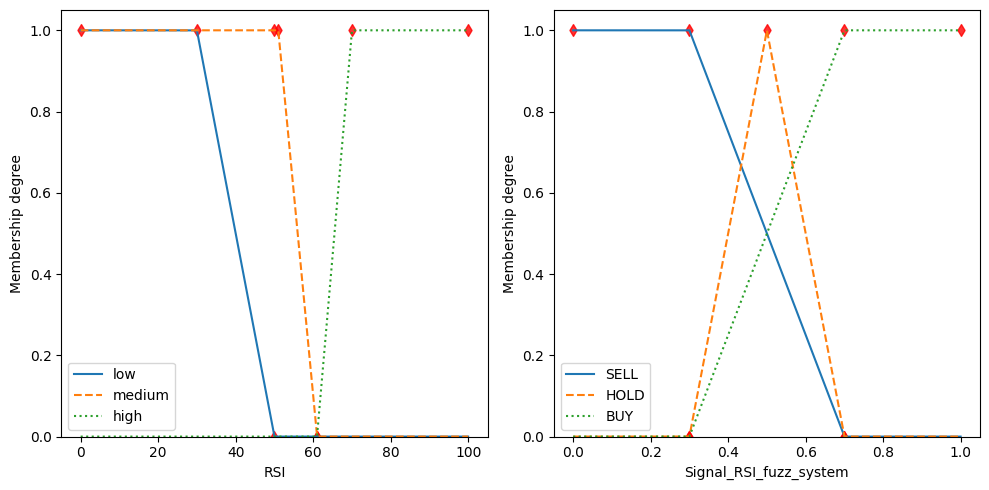

In [10]:
FS.produce_figure('Signal_RSI_fuzz_system')

## RSI backtesting

In [25]:
# zmiana na datę i ustaw jako index
# data = data.set_index(pd.DatetimeIndex(data['Date']))
# zmiana decyzji na -1, 0, 1
data['dec_rsi'] = data['dec_rsi'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

* sl = Cena stop-loss, po której, jeśli zostanie ustawiona, nowe warunkowe zlecenie stop-market zostanie złożone dla transakcji następującej po realizacji tego zlecenia. Zobacz także Trade.sl.
* Trade.sl = Cena stop-loss, po której należy zamknąć transakcję. Ta zmienna jest zapisywalna. Przypisując jej nową wartość ceny, tworzysz lub modyfikujesz istniejące zlecenie SL. Przypisanie wartości None oznacza jego anulowanie.
* trade_on_close = True - zlecenia rynkowe wypełniane w odniesieniu do ceny zamknięcia bieżącego słupka zamiast
* hedging = True - transakcje w obu kierunkach
* exclusive_orders = True - każde nowe zlecenie automatycznie zamyka poprzednią transakcję/pozycję

# Williams %R ('r_percent')


In [12]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    # -80 (oversold)
    df.loc[df['r_percent'] <= -80, 'dec_will'] = 'BUY'
    # -20 (overbought)
    df.loc[df['r_percent'] >= -20, 'dec_will'] = 'SELL'

    return df



In [13]:
decision_williams(data)
data['dec_will'].value_counts()

dec_will
HOLD    786
BUY     263
SELL    236
Name: count, dtype: int64

In [14]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])

# S1 = sf.FuzzySet(points=[[0, 1.], [0.4, 1.], [0.6, 0.]], term="SELL")
# S2 = sf.FuzzySet(points=[[0.4, 0.], [0.5, 1.], [0.6, 0.]], term="HOLD")
# S3 = sf.FuzzySet(points=[[0.4, 0.], [0.6, 1.], [1.0, 1.]], term="BUY")
# LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS BUY)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS SELL)"
FS.add_rules([R1, R2, R3])

data['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [15]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    631
SELL    357
BUY     297
Name: count, dtype: int64

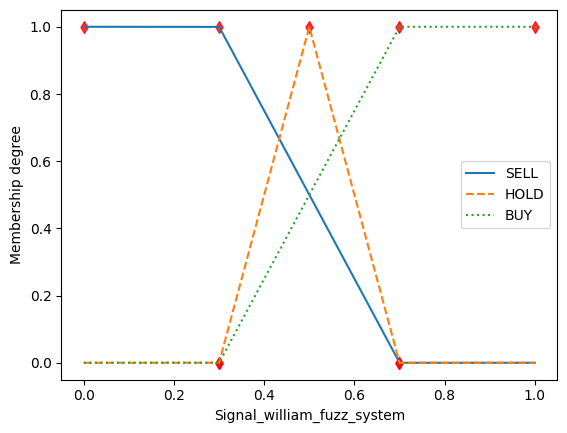

In [16]:
FS.plot_variable('Signal_william_fuzz_system')

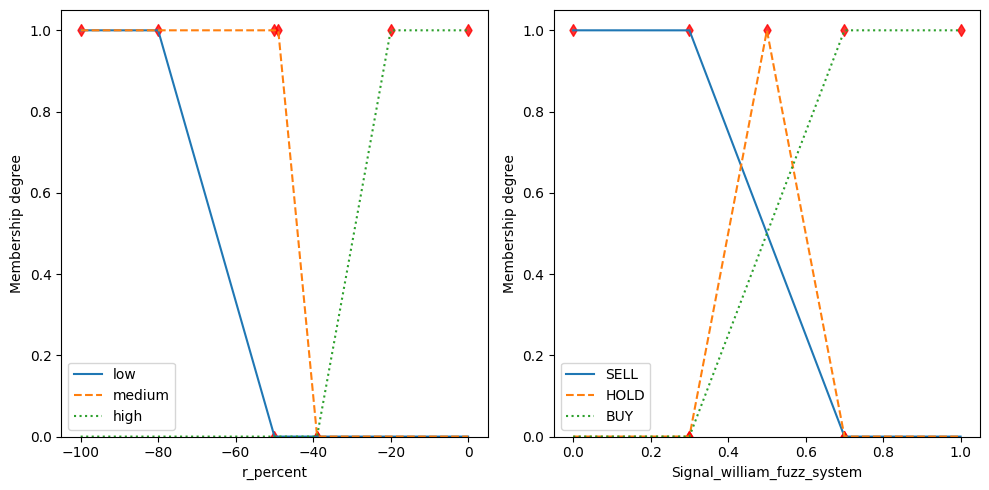

In [17]:
FS.produce_figure('Signal_william_fuzz_system')

# Williams backtesting

In [26]:
# zmiana decyzji na -1, 0, 1
data['dec_will'] = data['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['Signal_william_fuzz_system'] = data['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

In [27]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
 0    631
-1    357
 1    297
Name: count, dtype: int64

In [28]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system,dec_will,Signal_william_fuzz_system,prev_5MA,crossover,cross_MA
0,2019-05-01,1.121831,1.124999,1.121441,1.121604,1.121604,0,EURUSD=X,0.002755,0.002755,...,1.123754,1.133748,1.113760,0,0,0,0,NaN,None,HOLD
1,2019-05-02,1.120185,1.121818,1.117356,1.120084,1.120084,0,EURUSD=X,-0.001356,0.000000,...,1.123524,1.133638,1.113409,0,0,0,0,1.116837,None,HOLD
2,2019-05-03,1.117256,1.120072,1.114132,1.117356,1.117356,0,EURUSD=X,-0.002439,0.000000,...,1.123262,1.133743,1.112782,0,0,0,0,1.117784,None,HOLD
3,2019-05-06,1.118706,1.120448,1.117993,1.118581,1.118581,0,EURUSD=X,0.001096,0.001096,...,1.123093,1.133769,1.112417,0,0,0,0,1.118518,None,HOLD
4,2019-05-07,1.120448,1.121957,1.117606,1.120185,1.120185,0,EURUSD=X,0.001433,0.001433,...,1.122820,1.133501,1.112140,0,0,0,0,1.119229,None,HOLD


# MA decision



kupno - krótsza przecina dłuższą od dołu 

sprzedaż - krótsza przecina dłuższą od góry


In [29]:
# Ostre

data['prev_5MA'] = data['5MA'].shift(1)

data['crossover'] = np.where((data['5MA'] > data['15MA']) & (data['prev_5MA'] < data['15MA']), 'bullish crossover',
                                  np.where((data['5MA'] < data['15MA']) & (data['prev_5MA'] > data['15MA']), 'bearish crossover', None))

data['cross_MA'] = np.where(data['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(data['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))

data['crossover'].value_counts()



crossover
bearish crossover    55
bullish crossover    54
Name: count, dtype: int64

In [24]:
data['cross_MA'].value_counts()

cross_MA
HOLD    1176
SELL      55
BUY       54
Name: count, dtype: int64

In [30]:
# Calculating the difference between the shorter and longer average

data['diff_MA'] = data['5MA'] - data['15MA']

# Creation of 1 lagged column with difference in averages
data['diff_MA_prev'] = data['diff_MA'].shift(1)

data['diff_MA'].describe()

count    1285.000000
mean       -0.000157
std         0.007206
min        -0.029886
25%        -0.004629
50%        -0.000303
75%         0.004007
max         0.026677
Name: diff_MA, dtype: float64

In [31]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)
FS.add_linguistic_variable("diff_MA_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])


FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS medium) AND (diff_MA_prev IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS medium) AND (diff_MA_prev IS high) THEN (fuzz_MA_strategy IS SELL)"
R3 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS HOLD)"
R4 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", data.loc[data.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [32]:
data['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
HOLD    1249
SELL      20
BUY       16
Name: count, dtype: int64

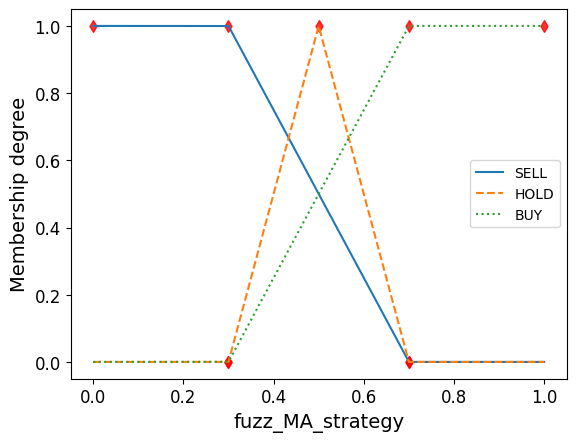

In [52]:
FS.plot_variable('fuzz_MA_strategy')

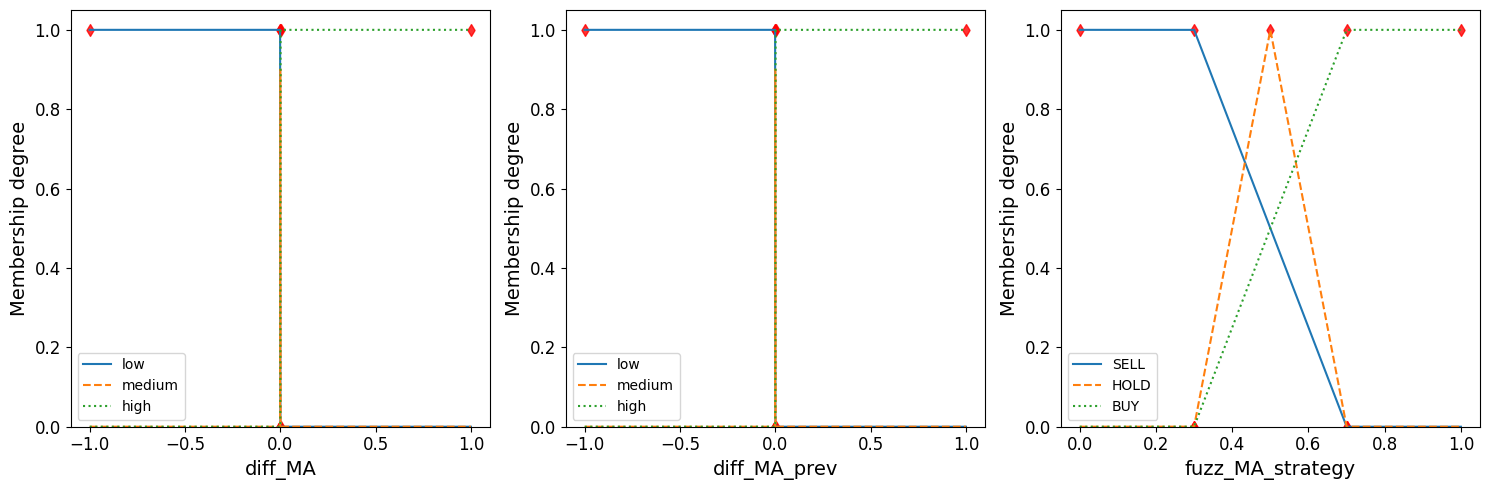

In [53]:
FS.produce_figure('fuzz_MA_strategy')

# MA backtesting

In [33]:
data['cross_MA'] = data['cross_MA'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['fuzz_MA_strategy'] = data['fuzz_MA_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


# MACD decision

In [34]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''
    
data['Signal_Line'] = data.groupby('Name')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

buy_condition = ((data['MACD'].shift(1) < data['Signal_Line'].shift(1)) & 
                 (data['MACD'] > data['Signal_Line']))  
               

sell_condition = ((data['MACD'].shift(1) > data['Signal_Line'].shift(1)) & 
                  (data['MACD'] < data['Signal_Line']))

data['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))

data[['MACD', 'Signal_Line']].describe()

,MACD,Signal_Line
count,1285.000000,1285.000000
mean,-0.000214,-0.000218
std,0.005328,0.005015
min,-0.014496,-0.011850
25%,-0.003910,-0.003557
50%,-0.000929,-0.000887
75%,0.002947,0.002763
max,0.014898,0.013506


In [37]:
data['MACD_decision'].value_counts()

MACD_decision
 0    1178
-1      54
 1      53
Name: count, dtype: int64

In [35]:
# Calculating the difference between MACD and Signal line
data['diff_MACD'] = data['MACD'] - data['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
data['diff_MACD_prev'] = data['diff_MACD'].shift(1)

In [58]:
data['diff_MACD'].describe()

count    1285.000000
mean        0.000004
std         0.001609
min        -0.006161
25%        -0.001090
50%        -0.000037
75%         0.001054
max         0.006193
Name: diff_MACD, dtype: float64

In [36]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 (0,001) i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0(0,001) i diff_MACD_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)
FS.add_linguistic_variable("diff_MACD_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS high) THEN (fuzz_MACD_strategy IS SELL)"
R3 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS HOLD)"
R4 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MACD']):
    FS.set_variable("diff_MACD", value)
    FS.set_variable("diff_MACD_prev", data.loc[data.index[i], 'diff_MACD_prev'])
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



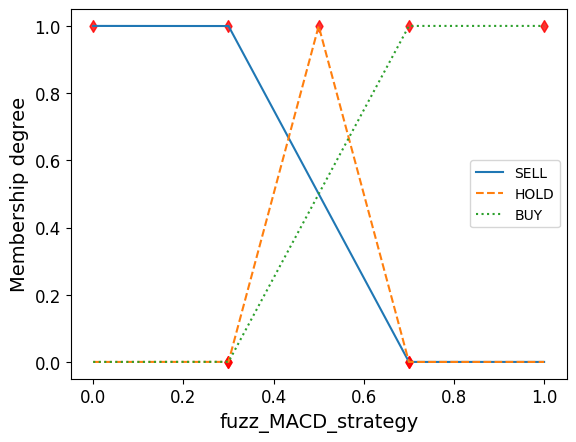

In [60]:
FS.plot_variable('fuzz_MACD_strategy')

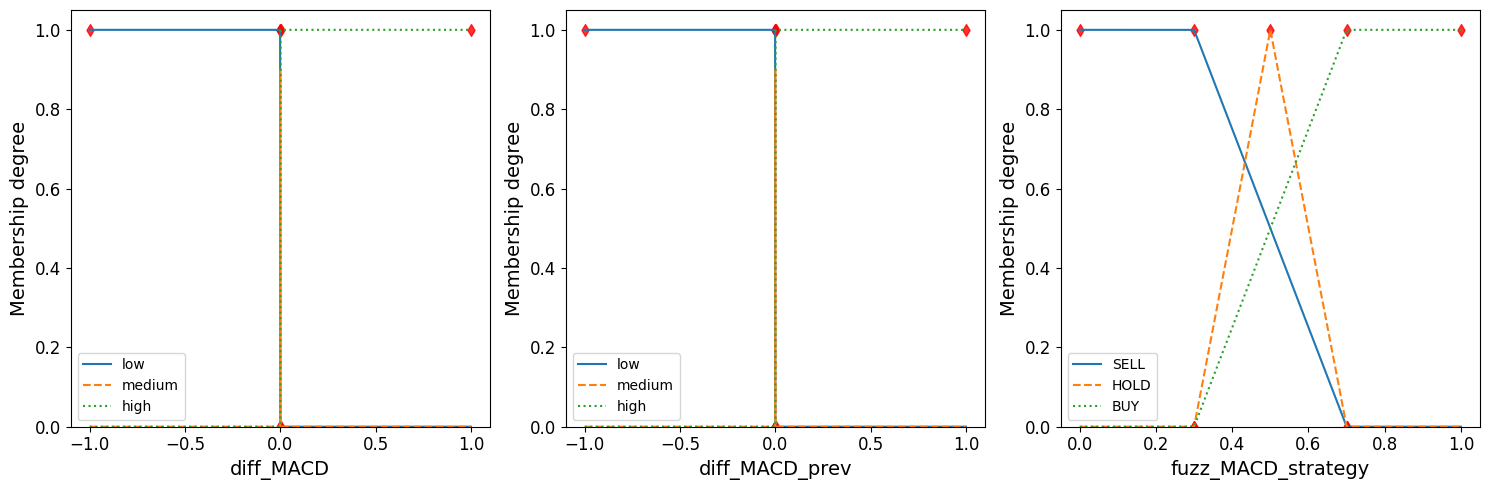

In [61]:
FS.produce_figure('fuzz_MACD_strategy')

# MACD backtesting

In [38]:
data['fuzz_MACD_strategy'] = data['fuzz_MACD_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


# Bollinger Bands decision

### Sharp

In [39]:
   '''
   'B_MA',
 'BU',
 'BL',
    close < BL - kup
    close > BU - sprzedaj
    '''
def decision_bollinger(df):
    df['dec_bollinger'] = 'HOLD'  

    df.loc[df['Close'] < df['BL'], 'dec_bollinger'] = 'BUY'
    df.loc[df['Close'] > df['BU'], 'dec_bollinger'] = 'SELL'

    return df

In [40]:
decision_bollinger(data)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,cross_MA,diff_MA,diff_MA_prev,fuzz_MA_strategy,Signal_Line,MACD_decision,diff_MACD,diff_MACD_prev,fuzz_MACD_strategy,dec_bollinger
0,2019-05-01,1.121831,1.124999,1.121441,1.121604,1.121604,0,EURUSD=X,0.002755,0.002755,...,0,-0.006730,NaN,0,-0.001862,0,0.000000,NaN,-1,HOLD
1,2019-05-02,1.120185,1.121818,1.117356,1.120084,1.120084,0,EURUSD=X,-0.001356,0.000000,...,0,-0.005279,-0.006730,0,-0.001850,0,0.000048,0.000000,0,HOLD
2,2019-05-03,1.117256,1.120072,1.114132,1.117356,1.117356,0,EURUSD=X,-0.002439,0.000000,...,0,-0.003964,-0.005279,0,-0.001870,-1,-0.000081,0.000048,0,HOLD
3,2019-05-06,1.118706,1.120448,1.117993,1.118581,1.118581,0,EURUSD=X,0.001096,0.001096,...,0,-0.002458,-0.003964,0,-0.001886,0,-0.000063,-0.000081,0,HOLD
4,2019-05-07,1.120448,1.121957,1.117606,1.120185,1.120185,0,EURUSD=X,0.001433,0.001433,...,0,-0.001437,-0.002458,0,-0.001868,1,0.000072,-0.000063,0,HOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,2024-03-28,1.081338,1.082837,1.077551,1.081338,1.081338,0,EURUSD=X,-0.001753,0.000000,...,0,-0.005601,-0.003699,0,0.000843,0,-0.001162,-0.001034,0,HOLD
1281,2024-03-29,1.079447,1.080731,1.076890,1.079447,1.079447,0,EURUSD=X,-0.001750,0.000000,...,0,-0.005921,-0.005601,0,0.000516,0,-0.001309,-0.001162,0,HOLD
1282,2024-04-01,1.079273,1.080147,1.073157,1.079273,1.079273,0,EURUSD=X,-0.000162,0.000000,...,0,-0.005216,-0.005921,0,0.000179,0,-0.001349,-0.001309,0,HOLD
1283,2024-04-02,1.073722,1.077877,1.072536,1.073722,1.073722,0,EURUSD=X,-0.005156,0.000000,...,0,-0.005942,-0.005216,0,-0.000236,0,-0.001659,-0.001349,0,BUY


In [41]:
data['dec_bollinger'].value_counts()

dec_bollinger
HOLD    1147
BUY       69
SELL      69
Name: count, dtype: int64

### Fuzzy

In [42]:
'''
    diff_cl_BL < 0 - kup
    diff_cl_BU > 0 - sprzedaj
'''

data['diff_cl_BU'] = data['Close'] - data['BU']
data['diff_cl_BL'] = data['Close'] - data['BL']

data['prev_diff_cl_BU'] = data['diff_cl_BU'].shift(1)
data['prev_diff_cl_BL'] = data['diff_cl_BL'].shift(1)


In [43]:
data[['diff_cl_BU', 'diff_cl_BL']].describe()

,diff_cl_BU,diff_cl_BL
count,1285.000000,1285.000000
mean,-0.016643,0.016060
std,0.013914,0.014653
min,-0.082142,-0.011002
25%,-0.024052,0.005856
50%,-0.013501,0.012069
75%,-0.006930,0.022098
max,0.009087,0.080340


In [44]:
# Fuzzy System initialization
FS = sf.FuzzySystem()

# Define linguistic variables for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [0, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_cl_BU", LV)
FS.add_linguistic_variable("diff_cl_BL", LV)
FS.add_linguistic_variable("prev_diff_cl_BU", LV)
FS.add_linguistic_variable("prev_diff_cl_BL", LV)

# Define linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_BB_strategy", LV)

# Define fuzzy rules

R1 = "IF (diff_cl_BU IS medium) AND (prev_diff_cl_BU IS low) THEN (fuzz_BB_strategy IS SELL)"
R2 = "IF (diff_cl_BU IS high) AND (NOT (diff_cl_BU IS low)) THEN (fuzz_BB_strategy IS SELL)"

R3 = "IF (diff_cl_BL IS medium) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"
R4 = "IF (diff_cl_BL IS low) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"

R5 = "IF (diff_cl_BU IS low) THEN (fuzz_BB_strategy IS HOLD)"
R6 = "IF (diff_cl_BL IS high) THEN (fuzz_BB_strategy IS HOLD)"


FS.add_rules([R1, R2, R3, R4, R5, R6])


# Initialize fuzzy MACD strategy column
data['fuzz_BB_strategy'] = 'HOLD'

# Perform fuzzy inference and generate signals
for i, row in data.iterrows():
    diff_cl_BU = row['diff_cl_BU']
    diff_cl_BU_prev = row['prev_diff_cl_BU']
    diff_cl_BL = row['diff_cl_BL']
    diff_cl_BL_prev = row['prev_diff_cl_BL']

    FS.set_variable("diff_cl_BU", diff_cl_BU)
    FS.set_variable("prev_diff_cl_BU", diff_cl_BU_prev)
    FS.set_variable("diff_cl_BL", diff_cl_BL)
    FS.set_variable("prev_diff_cl_BL", diff_cl_BL_prev)

    decision = FS.Mamdani_inference()['fuzz_BB_strategy']
    if decision >= 0.7:
        data.at[i, 'fuzz_BB_strategy'] = 'BUY'
    elif decision <= 0.3:
        data.at[i, 'fuzz_BB_strategy'] = 'SELL'


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



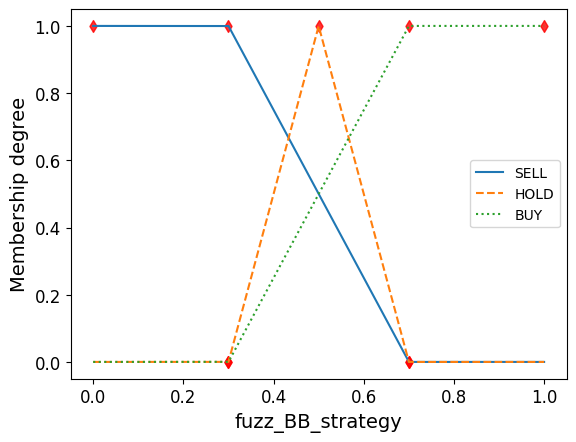

In [70]:
FS.plot_variable('fuzz_BB_strategy')

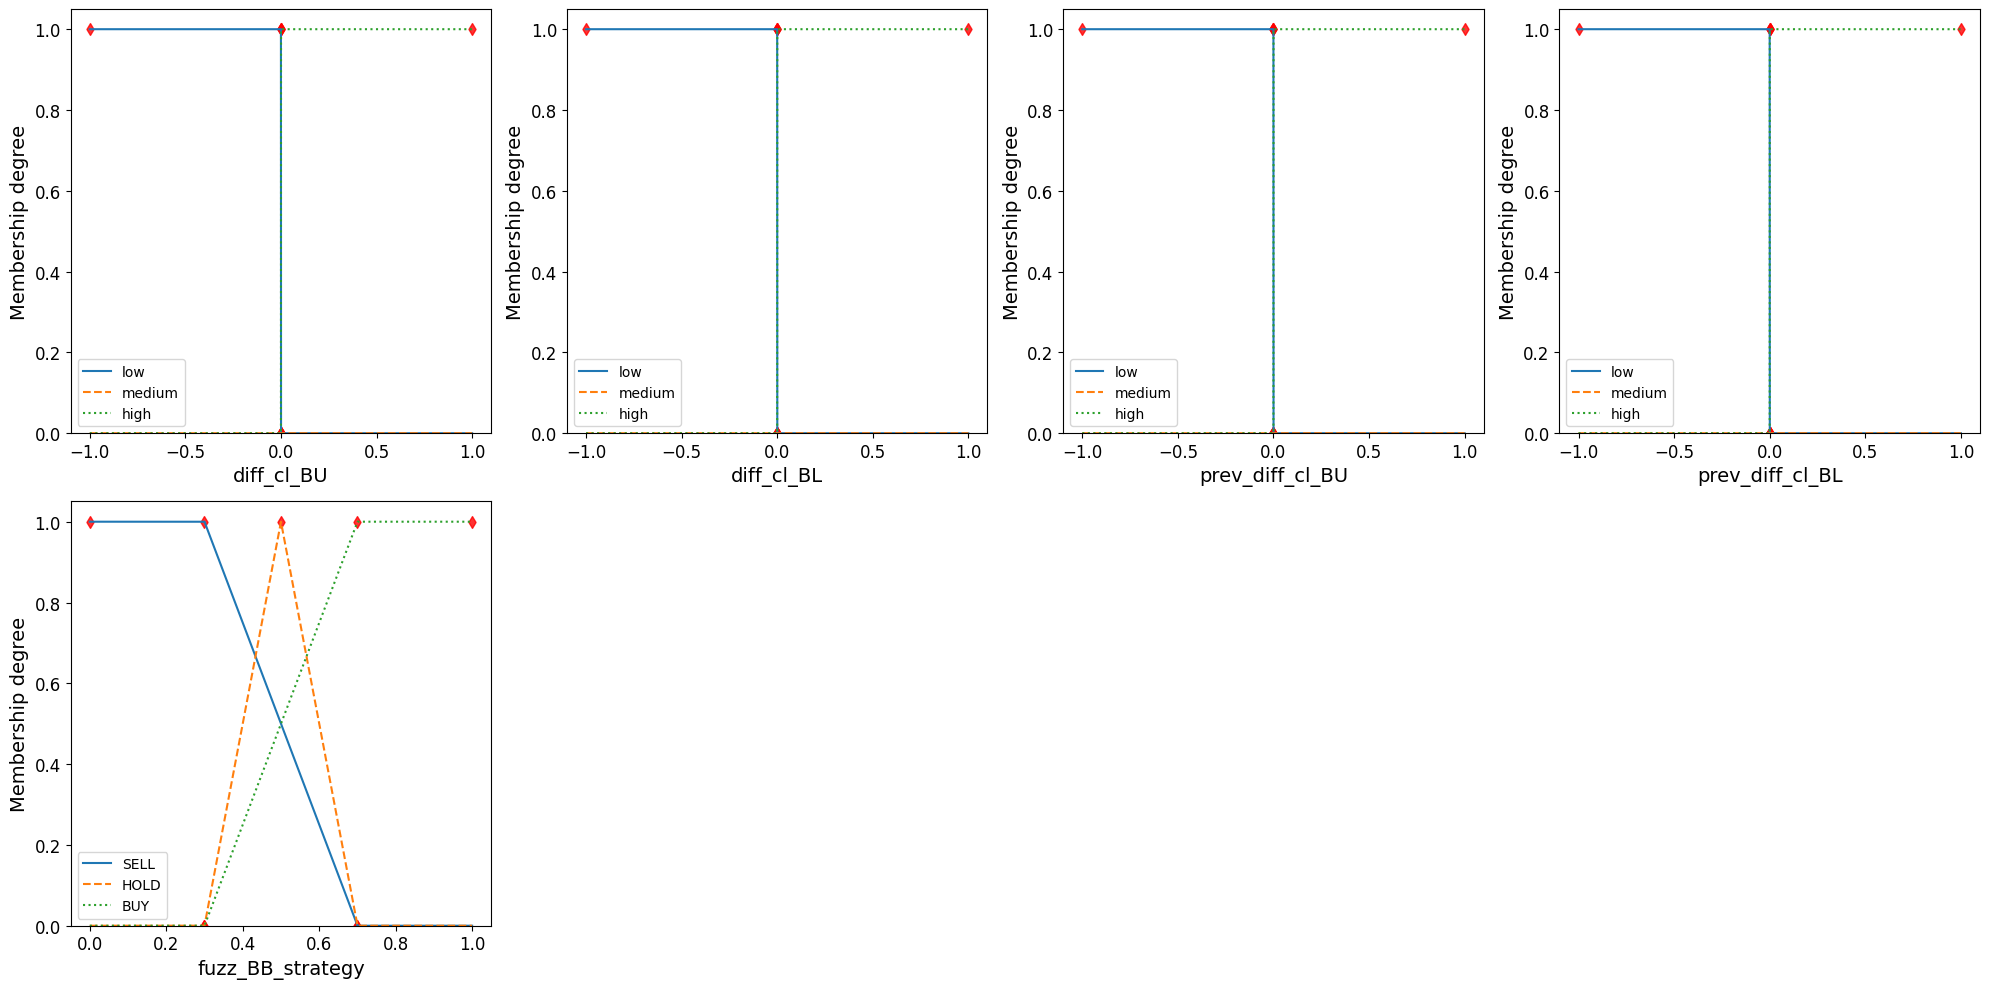

In [71]:
FS.produce_figure('fuzz_BB_strategy')

In [72]:
data['fuzz_BB_strategy'].value_counts()

fuzz_BB_strategy
HOLD    1187
SELL      69
BUY       29
Name: count, dtype: int64

# Bollinger Bands backtesting

In [45]:
data['dec_bollinger'] = data['dec_bollinger'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['fuzz_BB_strategy'] = data['fuzz_BB_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

In [190]:
# data.to_csv("data/decisions_EURUSD_5Y.csv", encoding='utf-8-sig')

In [46]:
drop_first = data.drop(data.index[0])
drop_first.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,MACD_decision,diff_MACD,diff_MACD_prev,fuzz_MACD_strategy,dec_bollinger,diff_cl_BU,diff_cl_BL,prev_diff_cl_BU,prev_diff_cl_BL,fuzz_BB_strategy
1,2019-05-02,1.120185,1.121818,1.117356,1.120084,1.120084,0,EURUSD=X,-0.001356,0.000000,...,0,0.000048,0.000000,0,0,-0.013554,0.006675,-0.012144,0.007844,0
2,2019-05-03,1.117256,1.120072,1.114132,1.117356,1.117356,0,EURUSD=X,-0.002439,0.000000,...,-1,-0.000081,0.000048,0,0,-0.016387,0.004574,-0.013554,0.006675,0
3,2019-05-06,1.118706,1.120448,1.117993,1.118581,1.118581,0,EURUSD=X,0.001096,0.001096,...,0,-0.000063,-0.000081,0,0,-0.015189,0.006163,-0.016387,0.004574,0
4,2019-05-07,1.120448,1.121957,1.117606,1.120185,1.120185,0,EURUSD=X,0.001433,0.001433,...,1,0.000072,-0.000063,0,0,-0.013316,0.008045,-0.015189,0.006163,0
5,2019-05-08,1.118956,1.121500,1.118956,1.119107,1.119107,0,EURUSD=X,-0.000963,0.000000,...,0,0.000100,0.000072,0,0,-0.013974,0.007306,-0.013316,0.008045,0


In [47]:
drop_first.to_csv("data/decisions_EURUSD_5Y.csv", encoding='utf-8-sig', index=False)

## [References](#References)

#### [Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)

exclusive_orders = False/True - sprawdzić czy lepiej 
przy rozmywaniu w pętli for zmienic progi decyzyjne
przy tworzeniu strategii sprawdzić jak działa sl i zastosować
pobawić się z stop loss i take profit


def init(self):
        super().init()
        signal = self.set_signal(data['dec_rsi'])
        if signal == 1: #rozne od self.position.long
            self.buy(size=.4, sl=.9)
        elif signal == -1:
            self.sell(size=.4, sl=.9)
        super().next()

- Ustalić długość okresu;
- Dodać inne instrumenty (po skończeniu backtestingu i zatwierdzeniu ustawień);

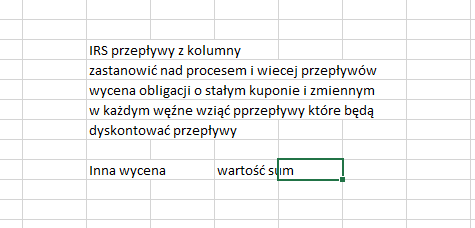

2 eseje

jeden z użyciem tylko GPT (15k znaków)

drugi co sądze o eseju co napisał chat (10k znaków)

opisać listę wejściową do chatu
wytknąć błędy 
sposób udoskonalania


TERMIN: 27.06

71T@DSm24 - biznes w it